# COGS 108 - EDA Checkpoint

# Names

- Clara Yi
- Ernest Lin
- Wesley Nguyen
- Ethan Lee
- Stephen Kim

<a id='research_question'></a>
# Research Question

Do the macroscopic socioeconomic features of a state, specifically median income, percentage of population without health insurance, and prevalence of blue collar workers, have a correlation to COVID infection and mortality rates in 2020-2021?

# Setup

In [117]:
!pip3 install pandas
!pip install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install openpyxl
!pip3 install sklearn
!pip3 install patsy 
!pip3 install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
/bin/bash: pip: command not found
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Data Cleaning

## Dataset 1 (COVID)
- With the imported data, we removed unncessary states. We only want the 50 states not including territories or DC
- We then removed the columns that we didn't need for analysis. We did this by selecting the columns that we needed
- We also wanted the dates to appear in a sortable/searchable way, so we made the dates arranged in yyyy-mm-dd format
- The data was then saved as a csv file.

**Note**: Since the data is arranged by date, we created a function ```read_covid_data``` that will return the 50 states with their respective data for just that specified date

## Dataset 1 Code

In [118]:
# Cleaning State Data
def clean_covid_data():
    # Date Closure
    def apply_date(date: str) -> str:
        split_date = date.split("/")
        return "/".join([split_date[2], split_date[0], split_date[1]])
        
    
    # Read the data (already in tabular form)
    covid_data_url = r"./Raw Data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv"
    covid_data = pd.read_csv(covid_data_url)
    
    # States we will not be looking at (These aren't part of the 50 states)
    remove_states = ["RMI", "FSM", "GU", "MP", "PW", "NYC", "PR", "AS", "VI", "DC"]
    covid_data = covid_data[~covid_data["state"].isin(remove_states)]
    
    # Remove columns we don't need
    covid_data = covid_data[["submission_date", "state", "tot_cases", "tot_death"]]
    
    # Change Date format to allow for easier sorting
    covid_data["submission_date"] = covid_data["submission_date"].apply(apply_date)
    
    # Sort Date
    covid_data.sort_values("submission_date", inplace=True, ascending=False)
    covid_data.reset_index(inplace=True, drop=True)
    
    # Save Data
    clean_covid_data_url = r"Cleaned Data/state_covid_data.csv"
    covid_data.to_csv(clean_covid_data_url, index=False)
    
clean_covid_data()

In [119]:
def read_covid_data(month: int, day: int, year: int):
    #retrieve cleaned csv
    covid_data_url = r"Cleaned Data/state_covid_data.csv"
    covid_data = pd.read_csv(covid_data_url)
    
    #reformat date parameter to match data values in csv, then get all data from specific date
    date_filter = formatDate(month, day, year)
    covid_data = covid_data[covid_data["submission_date"] == date_filter]
    covid_data.sort_values("state", inplace=True)
    covid_data.reset_index(inplace=True, drop=True)
    
    return covid_data

def formatPreZero(num: int) -> str:

    #adds '0' char to any integer less than 10 to match formatting
    if num >= 10:
        return str(num)
    
    return "0" + str(num)
    
#reformat date parameter to match data values in csv    
def formatDate(month: int,  day: int, year: int) -> str:
    return f"{year}/{formatPreZero(month)}/{formatPreZero(day)}"

## Dataset 2 (Labor)
- The raw data file for Dataset 2 is an excel file. The format of the data was not organized in a way that complements dataframes, so we had a lot of unnecessary texts in the excel
read as data entries as well. 
- Our first step was to identify the columns and rows that we want, which are the 50 states. We removed unnecessary states (including U.S. territories) and removed all the extra
non-state entries that were read as rows.
- Another problem is that some names in the State column had some footnote numbers that were unintentionally read from the excel sheet. We solved this by removing all occurences of numbers and parentheses from the State column.
- Since other datasets use state codes and the original data uses state names, we had to transform state names in the States column to their corresponding state codes. We did this by defining a function ```to_state_code``` that uses a dictionary to map each state name to their state code.
- We had to reorganize the structure of the dataframe, as the original file had the data stacked on top of each other so each state had 3 rows in the Dataframe. We did so by separating the 
raw dataframe into three different dataframes, and then combining them into a single dataframe so we only have 50 rows.
- We then removed unnessary columns, such as data from other time periods (Our focus was December of 2020). We also combined the columns of job sectors into two groups relevant to our analysis: Blue collar (construction, mining, trade, leisure) and White collar (Financial, professional, education, government) jobs.
- Our final step for Dataset 3 is to export the cleaned dataset as a csv and save it to the "Cleaned Data" folder.

## Dataset 2 Code

In [120]:
#Copied from https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

def to_state_code(state_name):
    return us_state_to_abbrev[state_name]

In [121]:
def clean_labor_data():
    #Read excel file, renames first column to States and take out null rows
    raw_labor_data = pd.read_excel("./Raw Data/labor_dataset_raw.xlsx", header = 4)
    raw_labor_data.rename(columns={"Unnamed: 0": "State"}, inplace=True)
    raw_labor_data = raw_labor_data.dropna()

    #Take out data from 2021 and only keep 2020
    raw_labor_data = raw_labor_data[["State", "Dec.\n2020", "Dec.\n2020.1", "Dec.\n2020.2"]]
    
    non_states = ["Virgin Islands", "District of Columbia", "Puerto Rico"]

    #Removes all non official states from dataset
    for region in non_states:
        raw_labor_data = raw_labor_data[raw_labor_data["State"].str.contains(region)==False]

    #Reset index to start at 0
    raw_labor_data = raw_labor_data.reset_index(drop = True)

    #eliminated extra characters in state names
    raw_labor_data["State"] = raw_labor_data["State"].str.replace('\d+', '', regex=True)
    raw_labor_data["State"] = raw_labor_data["State"].str.replace('(', '', regex=True)
    raw_labor_data["State"] = raw_labor_data["State"].str.replace(')', '', regex=True)

    #Convert state names into codes (First two letters of each state name)
    raw_labor_data["State"] = raw_labor_data["State"].apply(lambda state_name: us_state_to_abbrev[state_name])

    #Original raw data has different columns stacked on top of each row, so we need to reorder the dataset.
    #Block 1 contains total, constructing and mining data
    block1 = raw_labor_data[:50]
    block1.columns = ["State", "Total", "Constructing", "Mining"]

    #Block 2 contains Trade, Financial and Professional
    block2 = raw_labor_data[50:100]
    block2.columns = ["State", "Trade", "Financial", "Professional"]

    #Block 3 contains Education, Leisure and Government
    block3 = raw_labor_data[100:]
    block3.columns = ["State", "Education", "Leisure", "Gov"]

    #merge all blocks into one dataframe
    labor_data = block1.merge(block2, on="State")
    labor_data = labor_data.merge(block3, on="State")

    #We only need data on white collar and blue collar, so we can combine each job sector to their respective group.
    labor_data["Blue_col"] = labor_data["Constructing"] + labor_data["Mining"] + labor_data["Trade"] + labor_data["Leisure"]
    labor_data["White_col"] = labor_data["Financial"] + labor_data["Professional"] + labor_data["Education"] + labor_data["Gov"]

    #Get rid of all other columns except State, White_col, Blue_col and Total
    labor_data.drop(columns = ["Constructing", "Mining", "Trade", "Financial", "Professional", "Education", "Leisure", "Gov"], inplace=True)
    #export as csv
    labor_data.columns = ['state','tot_jobs','blue_col','white_col']
    labor_data.to_csv('./Cleaned Data/state_labor_data.csv')

def get_labor_data():
    labor_data_url = './Cleaned Data/state_labor_data.csv'
    labor_data = pd.read_csv(labor_data_url)
    return labor_data

clean_labor_data()


## Dataset 3 (Income/Insurance)
- For Dataset 3, we have two primary steps in cleaning the data. The first step was manually inputting the data from the data sources to a CSV file via Google Sheets. This manual step was necessary due to the fact that the original data source did not have an option to directly extract/download the raw data. Since there were only 50 observations, we decided manual input was the best option. 

- Our second step for Dataset 3 was to import the data into this notebook. We uploaded the CSV file into our "Raw Data" folder, and then used read_csv to bring it into a dataframe, which is a usable format for our future analysis. After making sure there were no issues, we then saved it to the "Cleaned Data" folder.

## Dataset 3 Code

In [122]:
def standardize_income(string):
    string = string.strip()

    string = string.replace(',', '')
    return float(string)

# Cleaning socioeconomic data
def clean_socioeconomic_data():
    socioeconomic_data_url = r'./Raw Data/socioeconomic_data.csv'
    soci_data = pd.read_csv(socioeconomic_data_url)

    #simplify columns and replace Median Household income values with floats
    soci_data.columns = ['state', '%_no_insurance', 'median_income']
    soci_data['median_income'] = soci_data['median_income'].apply(standardize_income)

    soci_data['with_insurance'] = 100 - soci_data['%_no_insurance'] 

    # Saving to CSV
    clean_socioeconomic_data_url = r"./Cleaned Data/clean_socioeconomic_data.csv"
    soci_data.to_csv(clean_socioeconomic_data_url, index=False)
    
def get_socioeconomic_data():
    clean_socioeconomic_data_url = r"./Cleaned Data/clean_socioeconomic_data.csv"
    soci_data = pd.read_csv(clean_socioeconomic_data_url)
    return soci_data

clean_socioeconomic_data()

## Dataset 4 (US population)
- The raw data is in csv format with population census data from the US government. For our purposes, we only want the state name and the population in 2020. Although it is 2022, there is not yet a fully released dataset on 2021 population data aside from estimates, so it is fine that we only have 2020 populations and we will be conducting our analysis for 2020.

- Since there are also US territories included and DC, we remove those unwanted rows. We also want to store states as their state code rather than their full name. There are also problems with having the population stored as a string, so we do some formatting to make the population be stored as an integer. Finally, we apply some renaming and then our data cleaning is complete.

https://data.ers.usda.gov/reports.aspx?ID=17827

In [123]:
def clean_population_data():
    def format_population(pop: str) -> int:
        pop = pop.replace(",", "")
        return int(pop)
    # get population data
    population_data_url = r"Raw Data/PopulationReport.csv"
    pop_data = pd.read_csv(population_data_url)
    
    # keep only state name and total population 2020
    pop_data = pop_data[["Name", "Pop. 2020"]]
    
    # Remove unwanted Rows
    remove_rows = ["United States", "District of Columbia", "Puerto Rico", "Source: U.S. Census Bureau, 1990, 2000, 2010, 2020 Censuses of Population\n\n\n"]
    pop_data = pop_data[~pop_data["Name"].isin(remove_rows)]
    pop_data.dropna(inplace=True)
    
    # Change column name
    pop_data.columns = ["state", "total_population"]
    
    # Value formatting
    pop_data["total_population"] = pop_data["total_population"].apply(format_population)
    pop_data["state"] = pop_data["state"].apply(to_state_code)
    
    # save to cleaned data
    cleaned_population_data_url = "Cleaned Data/population.csv"
    pop_data.to_csv(cleaned_population_data_url, index=False)
    
def read_population_data():
    cleaned_population_data_url = "Cleaned Data/population.csv"
    pop_data = pd.read_csv(cleaned_population_data_url)
    return pop_data

clean_population_data()

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [125]:
def formatPreZero(num: int) -> str:

    #adds '0' char to any integer less than 10 to match formatting
    if num >= 10:
        return str(num)
    
    return "0" + str(num)
    
#reformat date parameter to match data values in csv    
def formatDate(month: int,  day: int, year: int) -> str:
    return f"{year}/{formatPreZero(month)}/{formatPreZero(day)}"

def read_covid_data(month: int, day: int, year: int):
    #retrieve cleaned csv
    covid_data_url = r"Cleaned Data/state_covid_data.csv"
    covid_data = pd.read_csv(covid_data_url)
    
    #reformat date parameter to match data values in csv, then get all data from specific date
    date_filter = formatDate(month, day, year)
    covid_data = covid_data[covid_data["submission_date"] == date_filter]
    covid_data.sort_values("state", inplace=True)
    covid_data.reset_index(inplace=True, drop=True)
    
    return covid_data

def get_labor_data():
    labor_data_url = 'Cleaned Data/state_labor_data.csv'
    labor_data = pd.read_csv(labor_data_url)
    return labor_data

def get_socioeconomic_data():
    clean_socioeconomic_data_url = "Cleaned Data/clean_socioeconomic_data.csv"
    soci_data = pd.read_csv(clean_socioeconomic_data_url)
    return soci_data

def get_population_data():
    cleaned_population_data_url = r"Cleaned Data/population.csv"
    pop_data = pd.read_csv(cleaned_population_data_url)
    return pop_data

def get_overall_data(month: int, day:int, year:int):
    covid_data = read_covid_data(month, day, year)
    soci_data = get_socioeconomic_data()
    labor_data = get_labor_data()
    pop_data = get_population_data()

    overall_df = pd.merge(labor_data, soci_data, left_on='state', right_on='state')
    overall_df = pd.merge(overall_df, covid_data, left_on='state', right_on='state')
    overall_df = pd.merge(overall_df, pop_data, left_on="state", right_on="state")
    overall_df.drop(["Unnamed: 0"], axis="columns", inplace=True)
    overall_df.columns = ['state', 'total_jobs', 'blue_collar', 'white_collar', '%_no_insurance', 'median_income', 
                          '%_with_insurance', 'submission_date', 'total_cases', 'total_deaths', "total_population"]


    overall_df['%_mortality_rate'] = (overall_df['total_deaths'] / overall_df['total_cases']) * 100
    overall_df['%_blue_collar'] = overall_df['blue_collar'] / overall_df['total_jobs'] * 100
    overall_df['%_white_collar'] = overall_df['white_collar'] / overall_df['total_jobs'] * 100
    overall_df["%_infection_rate"] = (overall_df["total_cases"] / (overall_df["total_population"] - overall_df["total_deaths"])) * 100


    overall_df = overall_df[['state', 'total_jobs', 'blue_collar', '%_blue_collar', 'white_collar', '%_white_collar', 
                            'median_income', '%_no_insurance', '%_with_insurance', 'submission_date', 'total_population', 
                            'total_cases', 'total_deaths',  '%_mortality_rate', '%_infection_rate']]
    return overall_df

## Consolidating/Combining Data

In [126]:
## YOUR CODE HERE
## UNIVARIATE
# scatter matrix between independent variables to see if there is indeed a correlation between each socioeconomic metric
# scatterplot 1 (median_income vs mortality_rate) and (median_income vs infection_rate) (wesley)
# scatterplot 2 (with_insurance vs morality_rate) and (with_insurance vs infection_rate) (wesley)
# scatterplot 3 (white_collar vs mortality_rate) and (white_collar vs infection_rate) (ethan)
# scatterplot 4 (alpha_coeff vs mortality_rate) and (alpha_coeff vs infection_rate) (clara)

## MULTIVARIATE
# linear regression for (mortality rate ~ median_income,with_insurance,white_collar) (stephen)
# linear regression for (infection rate ~ median_income, with_insurance, white_collar) (ernest)

column_1 = 'median income'
column_2 = 'without insurance'
column_3 = 'with insurance'
column_4 = 'blue collar'
column_5 = 'white collar'
column_6 = 'number of infections'
column_7 = 'number of deaths'
column_8 = 'mortality rate'

# state of california
ca_median_income = 50000
ca_without_insurance = 15
ca_with_insurance = 100-15

#blue = typically considered manual labor
ca_blue_labor = 30
ca_white_labor = 70

#define socioeconomic coefficient (prosperity coefficient)
def calculate_alpha(median_income, with_insurance, white_labor):
    alpha = ((((median_income/100000)*0.3333)) + (with_insurance/100)*0.3333 + (white_labor/100)*0.3333)
    return alpha
    
h_alpha = calculate_alpha(96400, 90, 90)

l_alpha = calculate_alpha(1, 1, 1)


print(h_alpha)
print(l_alpha)
#coefficient is some value between 0 and 1 based on each of the socioeconomic factors
#california = 0.8
#wyoming = 0.2

#independent = coefficient
#dependent = mortality rate
#this way, we can see a direct correlation between general socioeconomic factors and mortality rate

## linear regression, multivariate (variables taken separately)

0.9212412000000001
0.0066693329999999995


In [127]:
overall_df = get_overall_data(2, 1, 2022)
overall_df

,state,total_jobs,blue_collar,%_blue_collar,white_collar,%_white_collar,median_income,%_no_insurance,%_with_insurance,submission_date,total_population,total_cases,total_deaths,%_mortality_rate,%_infection_rate
0,AL,2012.5,924.9,45.957764,968.0,48.099379,54393.0,11.7,88.3,2022/02/01,5024279,1229938,17683,1.437715,24.566352
1,AK,304.1,115.8,38.079579,163.2,53.666557,74476.0,13.9,86.1,2022/02/01,733391,209564,1052,0.501995,28.615709
2,AZ,2860.3,1191.2,41.645981,1523.6,53.267140,66628.0,13.6,86.4,2022/02/01,7151502,1878211,26345,1.402665,26.360275
3,AR,1257.5,576.4,45.836978,599.2,47.650099,50540.0,10.9,89.1,2022/02/01,3011524,781396,9667,1.237145,26.030421
4,CA,15937.9,6396.3,40.132640,8559.3,53.704064,77358.0,8.9,91.1,2022/02/01,39538223,8423159,79382,0.942426,21.346696
5,CO,2626.7,1046.8,39.852286,1380.1,52.541211,82611.0,9.3,90.7,2022/02/01,5773714,1256557,11164,0.888459,21.805572
6,CT,1570.8,616.0,39.215686,867.5,55.226636,79043.0,7.0,93.0,2022/02/01,3605944,700640,10076,1.438114,19.484586
7,DE,442.3,173.2,39.158942,249.7,56.454895,69132.0,8.1,91.9,2022/02/01,989948,248447,2544,1.023961,25.161636
8,FL,8492.0,3684.1,43.383184,4353.2,51.262365,57435.0,16.3,83.7,2022/02/01,21538187,5593114,67649,1.209505,26.050181
9,GA,4449.8,1962.2,44.096364,2217.2,49.826959,58952.0,15.5,84.5,2022/02/01,10711908,2378278,33053,1.389787,22.270908


## Scatterplot 1: Impact of Median Income

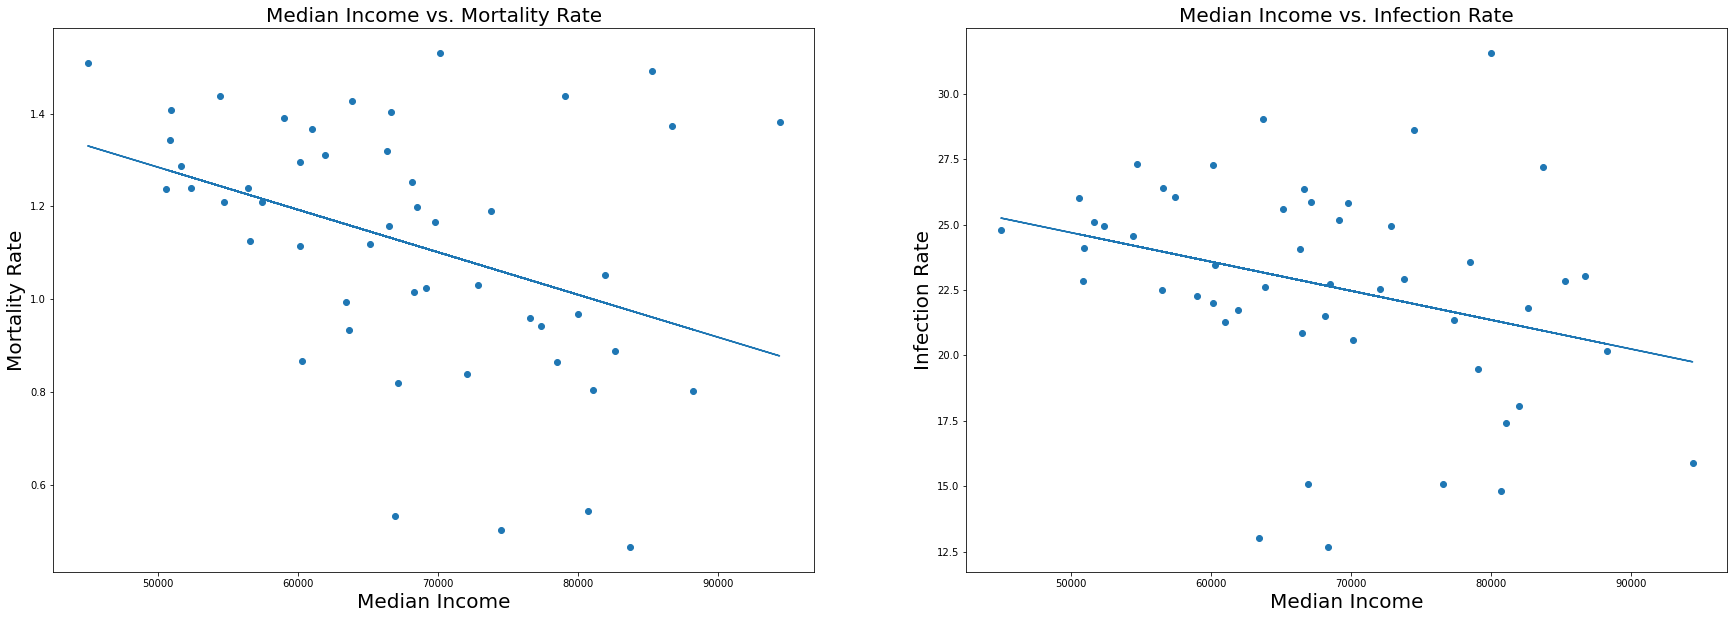

In [128]:
# scatterplot 1 (median_income vs mortality_rate) and (median_income vs infection_rate) (wesley)

#initialize the figure and scatterplots
fig = plt.figure(figsize = (30, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

a1, b1 = np.polyfit(overall_df['median_income'], overall_df['%_mortality_rate'], 1)
a2, b2 = np.polyfit(overall_df['median_income'], overall_df['%_infection_rate'], 1)


#integrate data from overall_df/data from all states
ax1.scatter(overall_df['median_income'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['median_income'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Median Income vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Median Income', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Median Income vs. Infection Rate', fontsize = 20)
ax2.set_xlabel('Median Income', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)

ax1.plot(overall_df['median_income'], a1*overall_df['median_income'] + b1)
ax2.plot(overall_df['median_income'], a2*overall_df['median_income'] + b2)
plt.show()

## Scatterplot 2: Impact of Insured Population

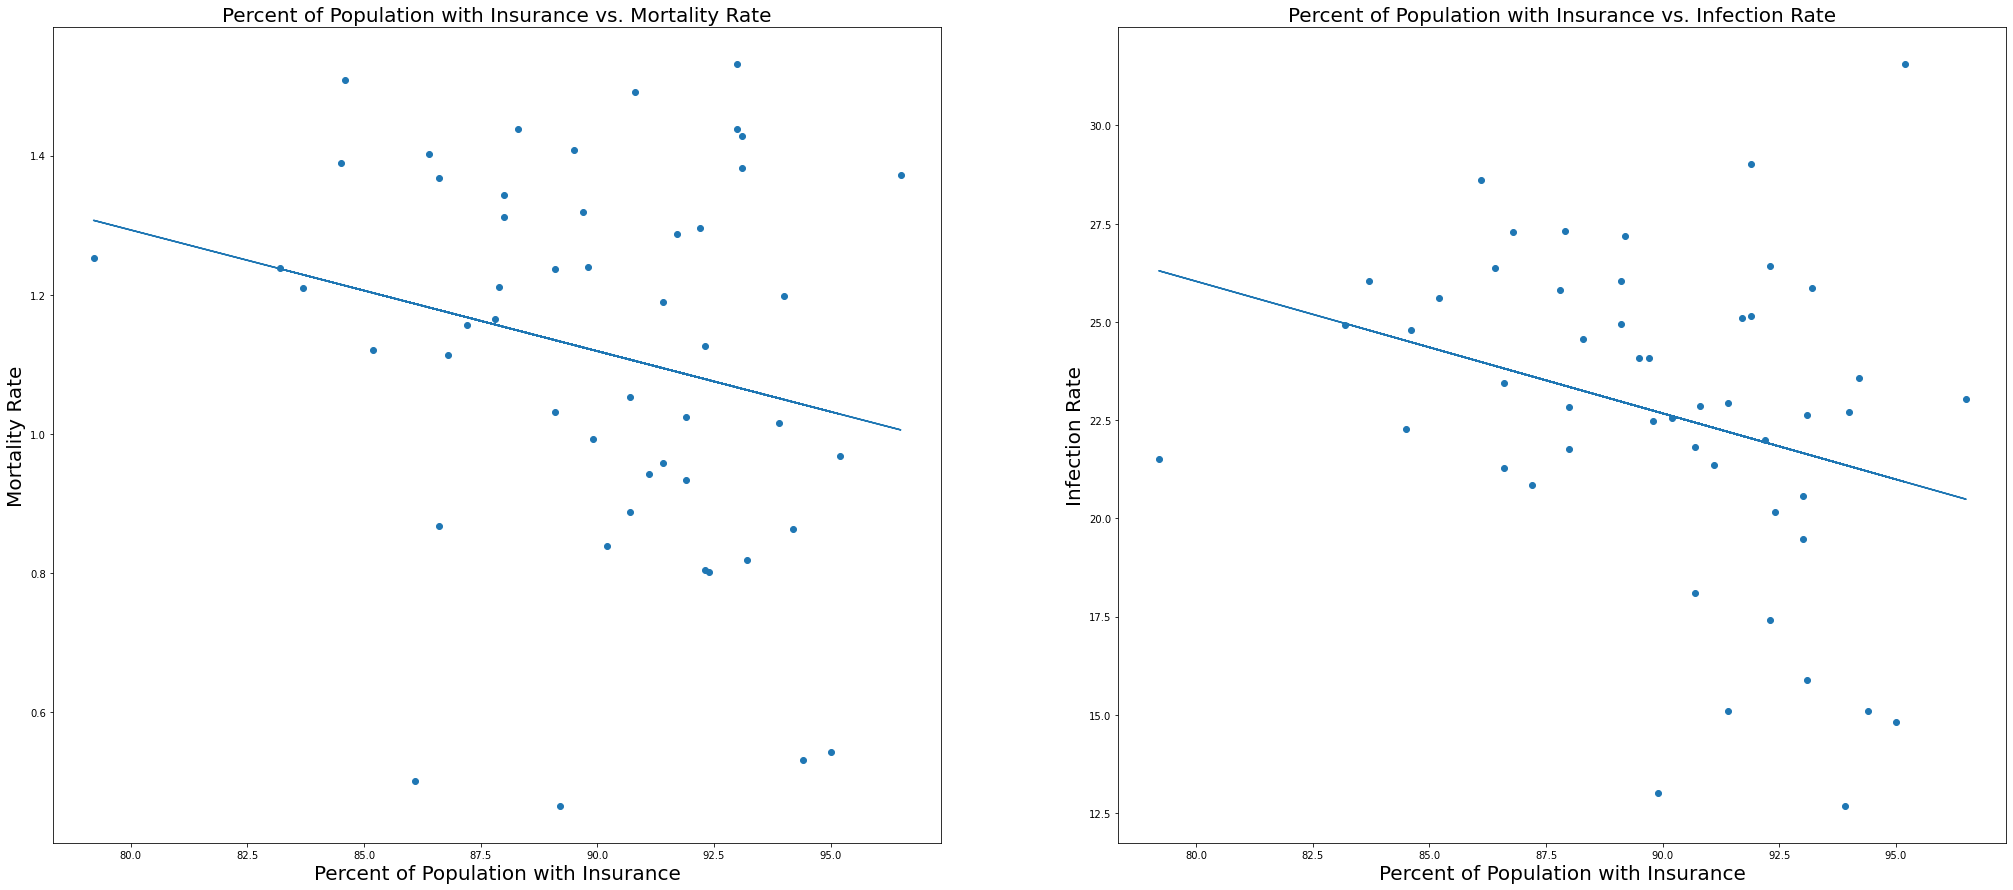

In [129]:
# scatterplot 2 (with_insurance vs morality_rate) and (with_insurance vs infection_rate) (wesley)

#initialize the figure and scatterplots
fig2 = plt.figure(figsize = (35, 15))
ax1 = fig2.add_subplot(121)
ax2 = fig2.add_subplot(122)

a1, b1 = np.polyfit(overall_df['%_with_insurance'], overall_df['%_mortality_rate'], 1)
a2, b2 = np.polyfit(overall_df['%_with_insurance'], overall_df['%_infection_rate'], 1)

#integrate data from overall_df/data from all states
ax1.scatter(overall_df['%_with_insurance'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['%_with_insurance'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Percent of Population with Insurance vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Percent of Population with Insurance', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Percent of Population with Insurance vs. Infection Rate', fontsize = 20)
ax2.set_xlabel('Percent of Population with Insurance', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)


ax1.plot(overall_df['%_with_insurance'], a1*overall_df['%_with_insurance'] + b1)
ax2.plot(overall_df['%_with_insurance'], a2*overall_df['%_with_insurance'] + b2)
plt.show()

## Scatterplot 3: Impact of Labor Distribution

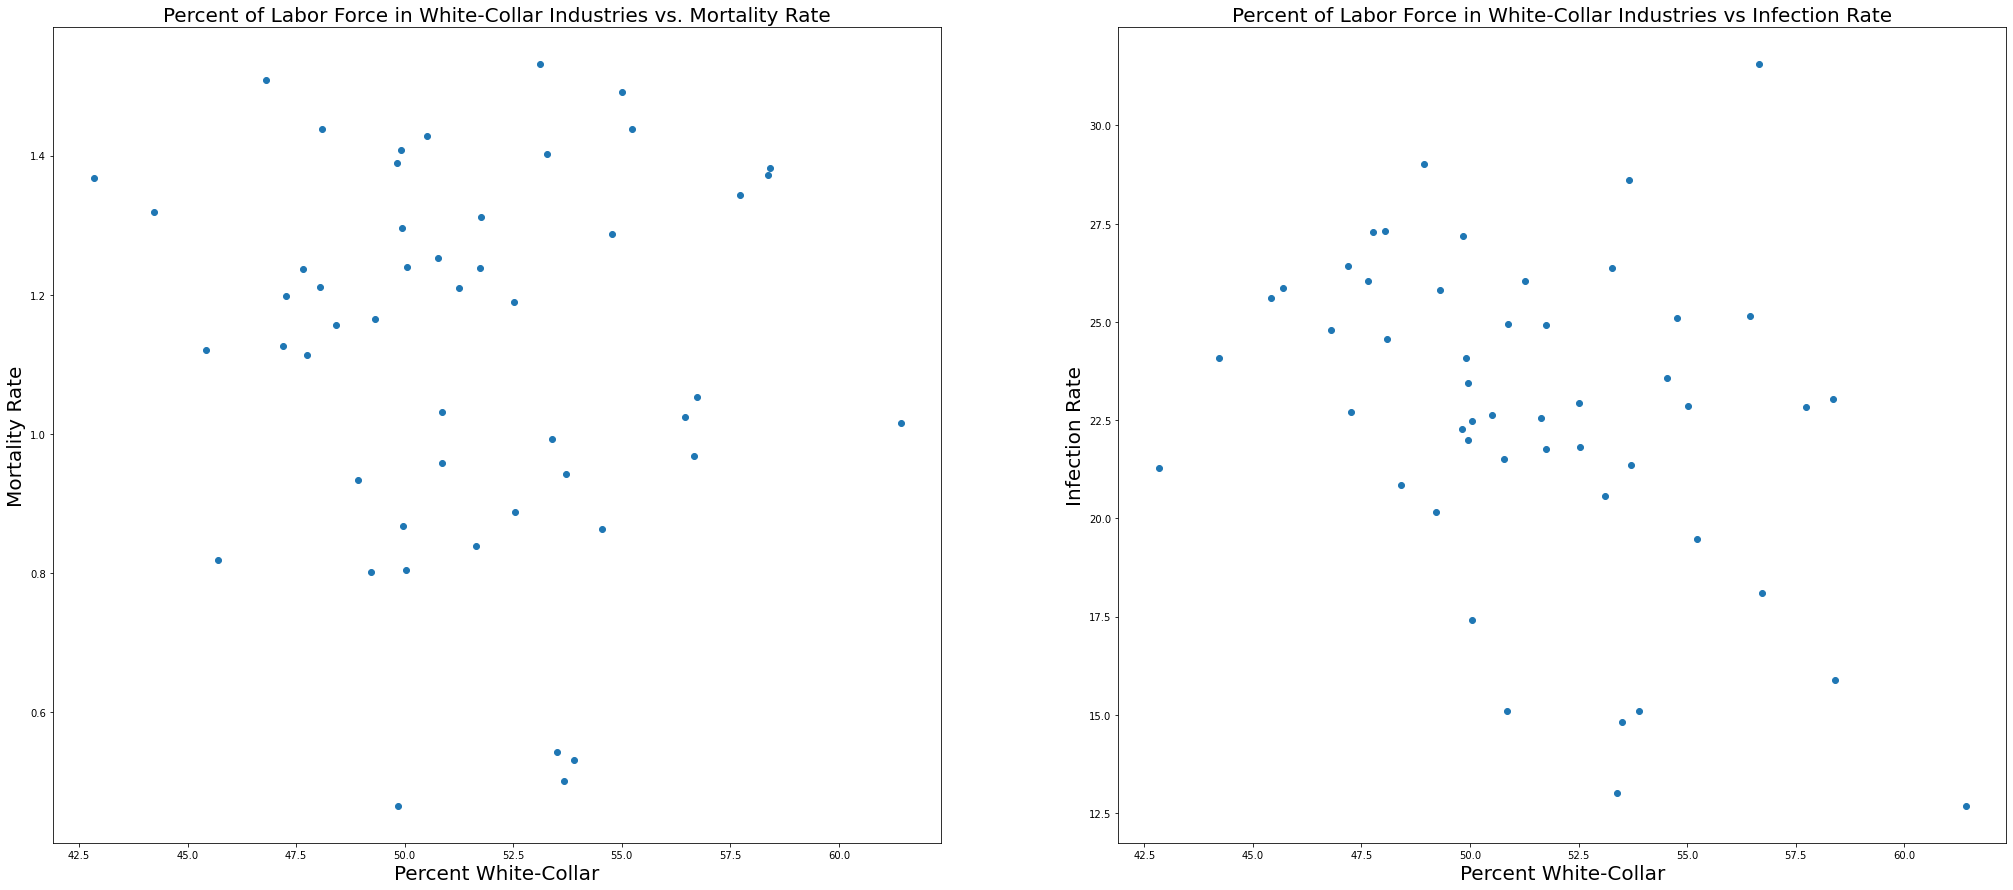

In [130]:
# scatterplot 3 (%_white_collar vs morality_rate) and (%_white_collar vs infection_rate)

#initialize the figure and scatterplots
fig3 = plt.figure(figsize = (35, 15))
ax1 = fig3.add_subplot(121)
ax2 = fig3.add_subplot(122)

#integrate data from overall_df/data from all states
ax1.scatter(overall_df['%_white_collar'], overall_df['%_mortality_rate'])
ax2.scatter(overall_df['%_white_collar'], overall_df['%_infection_rate'])

#titles and axis labels
ax1.set_title('Percent of Labor Force in White-Collar Industries vs. Mortality Rate', fontsize = 20)
ax1.set_xlabel('Percent White-Collar', fontsize = 20)
ax1.set_ylabel('Mortality Rate', fontsize = 20)

ax2.set_title('Percent of Labor Force in White-Collar Industries vs Infection Rate', fontsize = 20)
ax2.set_xlabel('Percent White-Collar', fontsize = 20)
ax2.set_ylabel('Infection Rate', fontsize = 20)

plt.show()


## linear regression for mortality rate and all relevant variables

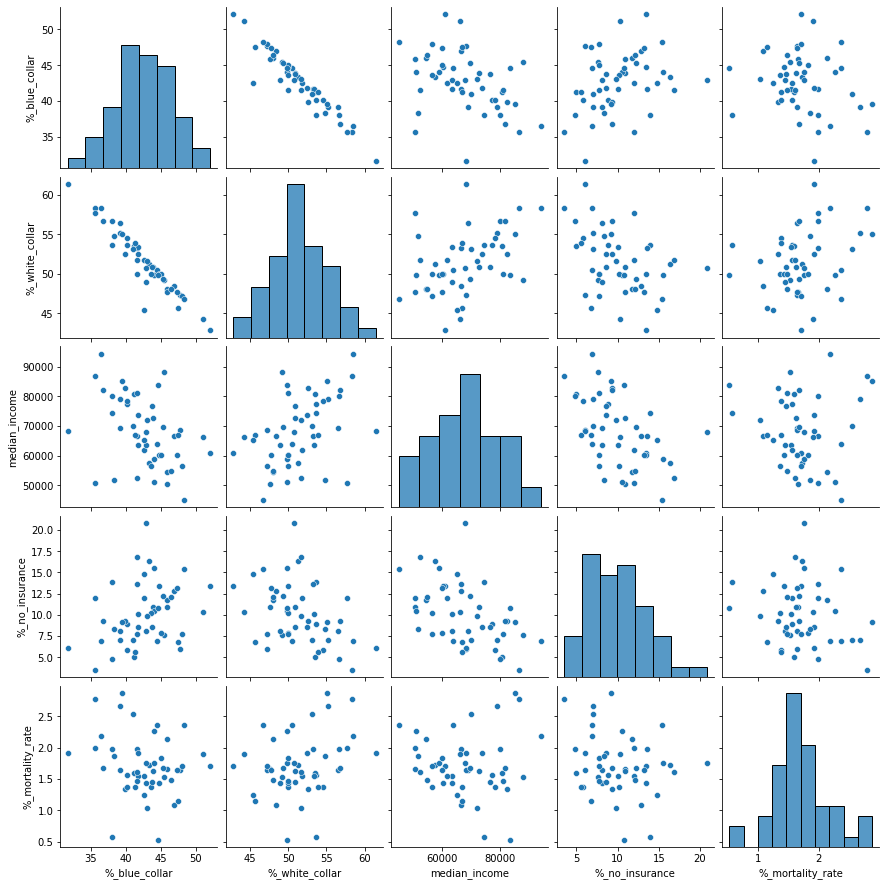

[ 7.60924995e-02  1.14823542e-01 -9.62896144e-06 -2.14400202e-02]


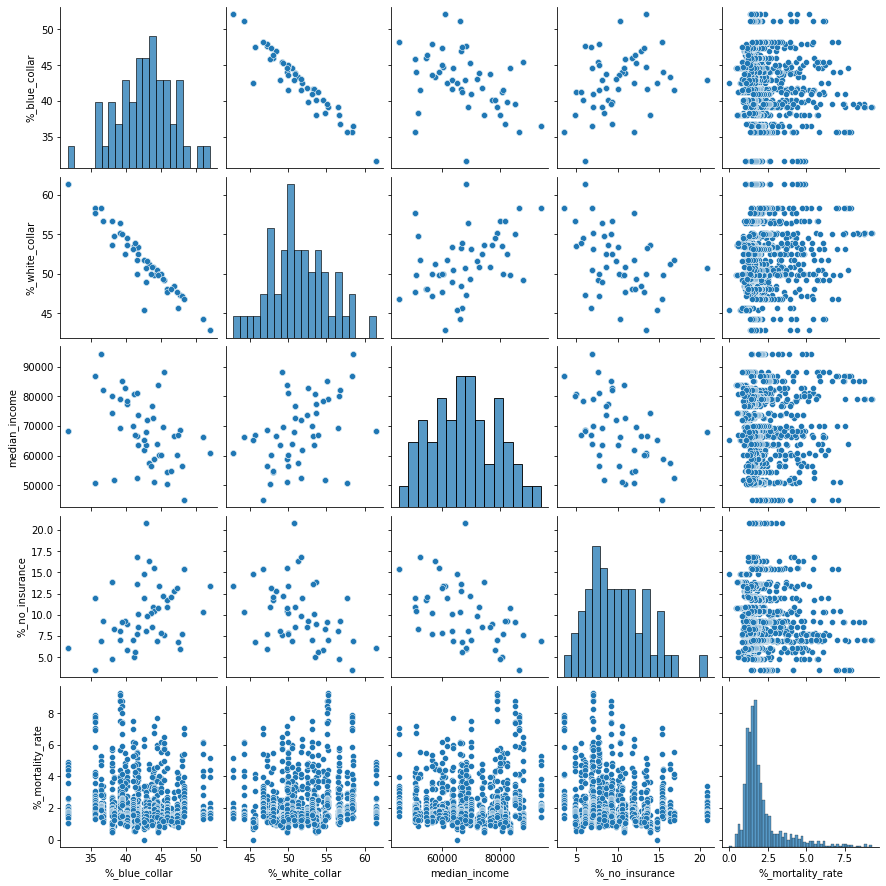

[ 1.21223158e-01  1.78085033e-01 -4.15049220e-06 -3.99881868e-02]


In [131]:
from sklearn import linear_model
# 1 day worth of data
mortality_regression_data = get_overall_data(3, 12, 2021)
mortality_regression_data = mortality_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_mortality_rate"]]

sns.pairplot(mortality_regression_data, kind="scatter")
plt.show()

mortality_X = mortality_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance"]]
mortality_Y = mortality_regression_data["%_mortality_rate"]

mortality_model = linear_model.LinearRegression()
mortality_model.fit(mortality_X, mortality_Y)

print(mortality_model.coef_)

# 23 days worth of data
data_points = [
    (4, 10, 2020),
    (5, 10, 2020),
    (6, 10, 2020),
    (7, 10, 2020),
    (8, 10, 2020),
    (9, 10, 2020),
    (10, 10, 2020),
    (11, 10, 2020),
    (12, 10, 2020),
    (1, 10, 2021),
    (2, 10, 2021),
    (3, 10, 2021),
    (4, 10, 2021),
    (5, 10, 2021),
    (6, 10, 2021),
    (7, 10, 2021),
    (8, 10, 2021),
    (9, 10, 2021),
    (10, 10, 2021),
    (11, 10, 2021),
    (12, 10, 2021),
    (1, 10, 2022),
    (2, 10, 2022)
]

mortality_regression_data = pd.DataFrame(columns=["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_mortality_rate"])

for point in data_points:
    df = get_overall_data(*point)
    df = df[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_mortality_rate"]]
    mortality_regression_data = pd.concat([mortality_regression_data, df], ignore_index=True)
    
sns.pairplot(mortality_regression_data, kind="scatter")
plt.show()

mortality_X = mortality_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance"]]
mortality_Y = mortality_regression_data["%_mortality_rate"]

mortality_model = linear_model.LinearRegression()
mortality_model.fit(mortality_X, mortality_Y)

print(mortality_model.coef_)

## linear regression for infection rate and all relevant variables

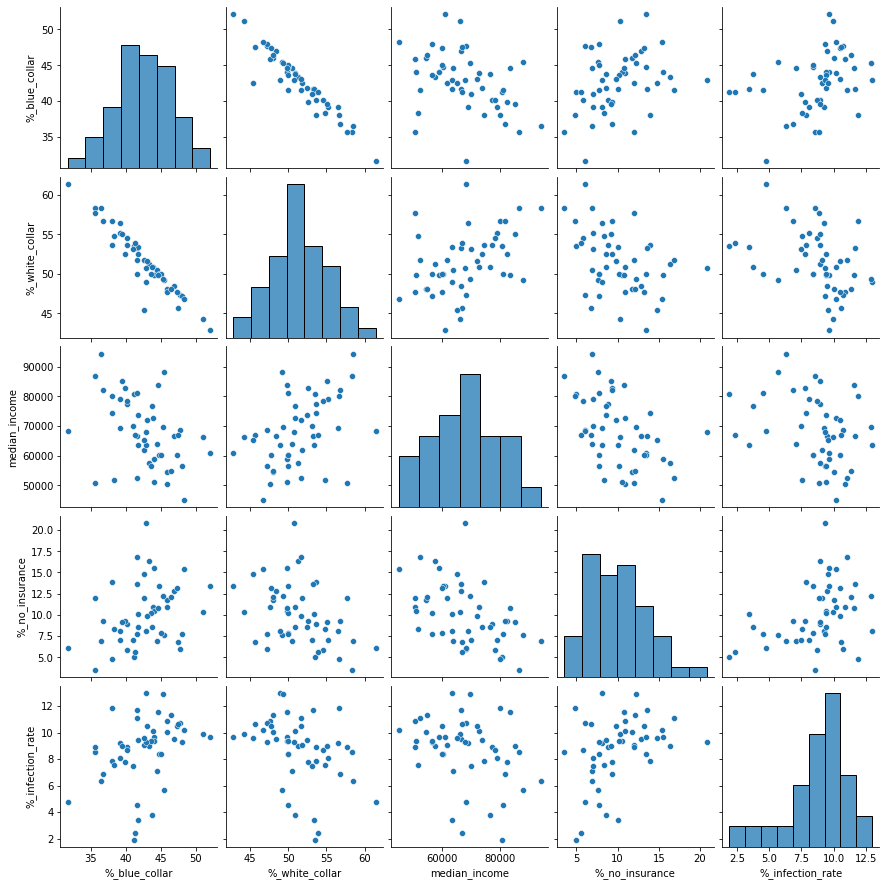

[ 3.66259223e-02 -1.23241457e-01 -1.97900866e-05  1.67233753e-01]


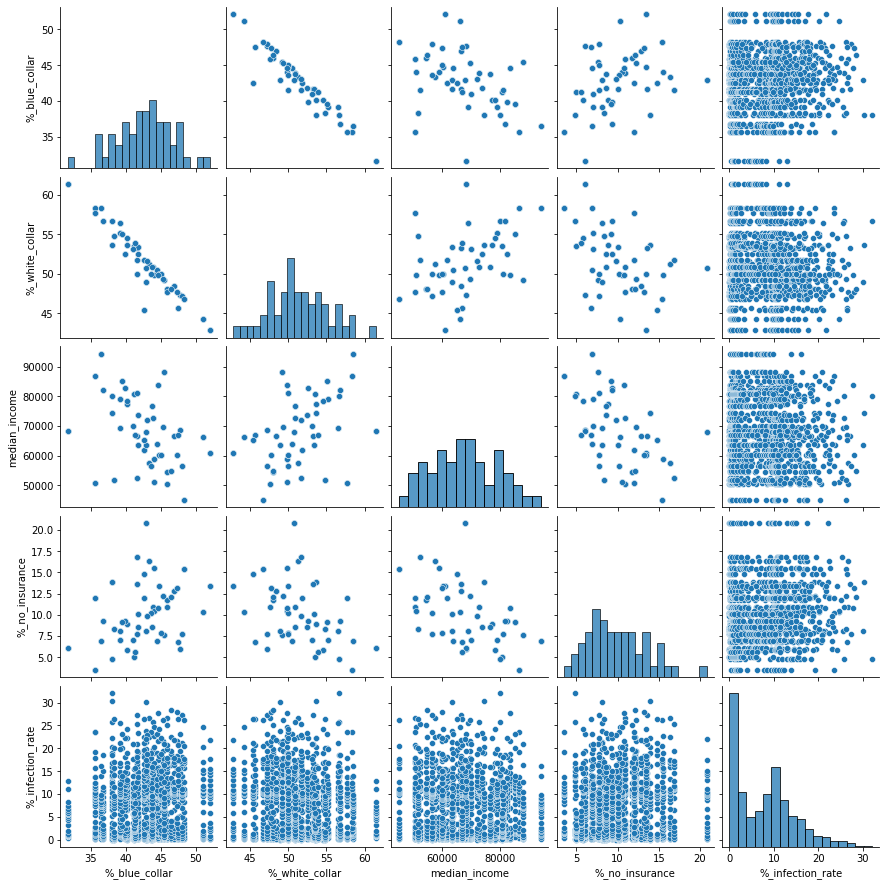

[-2.91902341e-02 -1.58555407e-01 -2.32830919e-05  1.15619925e-01]


In [132]:
from sklearn import linear_model
# 1 day worth of data
infection_regression_data = get_overall_data(3, 12, 2021)
infection_regression_data = infection_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_infection_rate"]]

sns.pairplot(infection_regression_data, kind="scatter")
plt.show()


infection_X = infection_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance"]]
infection_Y = infection_regression_data["%_infection_rate"]

infection_model = linear_model.LinearRegression()
infection_model.fit(infection_X, infection_Y)

print(infection_model.coef_)

infection_regression_data = pd.DataFrame(columns=["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_infection_rate"])

for point in data_points:
    df = get_overall_data(*point)
    df = df[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_infection_rate"]]
    infection_regression_data = pd.concat([infection_regression_data, df], ignore_index=True)
    
sns.pairplot(infection_regression_data, kind="scatter")
plt.show()

infection_X = infection_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance"]]
infection_Y = infection_regression_data["%_infection_rate"]

infection_model = linear_model.LinearRegression()
infection_model.fit(infection_X, infection_Y)

print(infection_model.coef_)

In [133]:
import patsy
import statsmodels.api as sm

infection_regression_data = get_overall_data(3, 12, 2021)
infection_regression_data = infection_regression_data[["%_blue_collar", "%_white_collar", "median_income", "%_no_insurance", "%_infection_rate"]]

#alternate linear regression approach
formula = """Q('%_infection_rate') ~ Q('%_white_collar')"""
data = infection_regression_data
dep, predictors = patsy.dmatrices(formula, data)
model = sm.OLS(dep, predictors)
res_1 = model.fit()
print(res_1.summary())


                              OLS Regression Results                             
Dep. Variable:     Q('%_infection_rate')   R-squared:                       0.145
Model:                               OLS   Adj. R-squared:                  0.127
Method:                    Least Squares   F-statistic:                     8.153
Date:                   Wed, 23 Feb 2022   Prob (F-statistic):            0.00633
Time:                           16:43:36   Log-Likelihood:                -112.21
No. Observations:                     50   AIC:                             228.4
Df Residuals:                         48   BIC:                             232.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte